In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pyscipopt
import time
import pickle
from pyscipopt import Model
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from data_loader import *
from utils import *
from bandit_utils import *

from enviornment import Enviornment
from reward import Reward
from lin_ucb import LinUCB

## Linear UCB on 5 minutes MIP instances

In [2]:
time_limit_in_mins = 5

In [3]:
actions = [{'veclendiving' : -1}, {'veclendiving' : 1}, {'veclendiving' : 10}]
action_values = list(map(lambda x: list(x.values())[0], actions))

seeds = [0,1,2,3,4]
priority_or_freq = 'freq'
min_time_to_solve = 5
max_rows = 100000
max_cols = 100000

max_primal_integral = time_limit_in_mins * 60 # set to no primal bound found in time limit
reward_path_prefix = '../solved_mip_results/rewards_' + str(time_limit_in_mins) +'_min/'
primal_integral_path_prefix = '../solved_mip_results/primal_integrals_' + str(time_limit_in_mins) +'_min/'

# dimension of state
state_dim = 5

In [4]:
# training parameters
episodes = 1000
n_runs = 10
seed = 1

# bandit parameters
results_dict_5_min = {}
#alphas = [1.0, 10.0]
alphas = [0.1, 0.5, 1.0, 5.0, 10.0]
#alphas = [1.0]

In [5]:
# load instances
instances = get_instances(actions = actions, 
                          seeds = seeds, 
                          priority_or_freq = priority_or_freq, 
                          max_primal_integral = max_primal_integral,
                          min_time_to_solve = min_time_to_solve,
                          max_rows = max_rows,
                          max_cols = max_cols,
                          reward_path_prefix = reward_path_prefix)

In [6]:
# get dict to store all primal integral results to avoid loading files every time
solved_mip_result_dict = get_solved_mip_result_dict(instances, priority_or_freq, actions, action_values, seeds, reward_path_prefix)

In [7]:
# get train/test split
train_instances, test_instances = get_train_test_split(instances, seed=seed)

print('Number of train instances:', len(train_instances))
print('Number of test instances:', len(test_instances))

Number of train instances: 268
Number of test instances: 68


In [8]:
# get scaler for training inputs
scaler = get_scaler_normalize_train_states(train_instances)

In [9]:
start_time = time.time()

np.random.seed(seed)

for alpha in alphas:
    
    print('alpha:', alpha)
    
    # init arrays to store results and bandit
    bandit = LinUCB(action_values, state_dim, alpha)
    train_rewards = []
    test_rewards = []
    
    for run in range(n_runs):

        print('  Run:', run+1)

        train_rewards_ep = []
        train_actions_ep = []

        test_rewards_ep = []
        test_actions_ep = []
        
        # eval before training
        train_reward, _ = eval_on_all(bandit, train_instances, solved_mip_result_dict=solved_mip_result_dict)
        test_reward, _ = eval_on_all(bandit, test_instances, solved_mip_result_dict=solved_mip_result_dict)
        train_rewards_ep.append(train_reward)
        test_rewards_ep.append(test_reward)

        for episode in range(episodes):

            if (episode + 1) % 500 == 0:
                print('    episode:', episode + 1, 'time:', time.time()-start_time)

            # get instance
            instance, state = get_random_instance(train_instances)
            state = scaler.transform(state.reshape(1,state_dim)).reshape(state_dim,)
            
            # get action
            action = bandit.get_action(state)

            
            reward = take_action_on_instance(solved_mip_result_dict, instance, action,)
            scaled_reward = scale_reward(reward, max_primal_integral)
            
            bandit.update_params(scaled_reward, state, action)

            train_reward, _ = eval_on_all(bandit, train_instances, solved_mip_result_dict=solved_mip_result_dict)
            test_reward, _ = eval_on_all(bandit, test_instances, solved_mip_result_dict=solved_mip_result_dict)
            train_rewards_ep.append(train_reward)
            test_rewards_ep.append(test_reward)

        train_rewards.append(train_rewards_ep)
        test_rewards.append(test_rewards_ep)
    
    results_dict_5_min[alpha] = {
        'train_rewards' : train_rewards,
        'test_rewards' : test_rewards,
        'train_rewards_mean' : np.mean(train_rewards, axis=0),
        'test_rewards_mean' : np.mean(test_rewards, axis=0),
        'train_rewards_std' : np.std(train_rewards, axis=0),
        'test_rewards_std' : np.std(test_rewards, axis=0),
        'bandit' : bandit
    }

alpha: 0.1
  Run: 1
    episode: 500 time: 110.35562133789062
    episode: 1000 time: 234.29402875900269
  Run: 2
    episode: 500 time: 357.5797207355499
    episode: 1000 time: 471.8245966434479
  Run: 3
    episode: 500 time: 592.9745354652405
    episode: 1000 time: 714.7628605365753
  Run: 4
    episode: 500 time: 842.2067792415619
    episode: 1000 time: 949.1959817409515
  Run: 5
    episode: 500 time: 1032.4216907024384
    episode: 1000 time: 1097.993082523346
  Run: 6
    episode: 500 time: 1162.5913293361664
    episode: 1000 time: 1228.2952461242676
  Run: 7
    episode: 500 time: 1317.173154592514
    episode: 1000 time: 1396.7331457138062
  Run: 8
    episode: 500 time: 1473.0032849311829
    episode: 1000 time: 1543.7998721599579
  Run: 9
    episode: 500 time: 1612.6678593158722
    episode: 1000 time: 1681.4097442626953
  Run: 10
    episode: 500 time: 1760.521448135376
    episode: 1000 time: 1834.4660720825195
alpha: 0.5
  Run: 1
    episode: 500 time: 1911.212554693

#### Plot Hyperparameter search

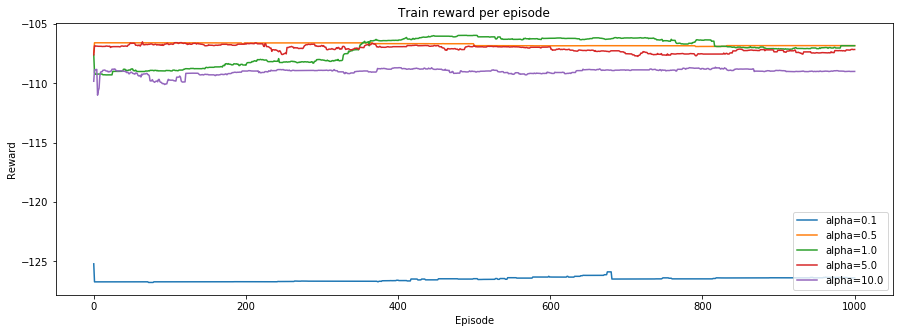

In [10]:
plt.figure(figsize = (15,5))

for alpha in alphas:
    train_rewards_mean = results_dict_5_min[alpha]['train_rewards_mean']
    plt.plot(train_rewards_mean, label = 'alpha='+str(alpha))

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train reward per episode')
plt.legend(loc='lower right')

plt.show()

##### Plot best results

In [11]:
best_alpha = 1.0

In [12]:
# get mean results for train and test
train_rewards_mean = results_dict_5_min[best_alpha]['train_rewards_mean']
train_rewards_std = results_dict_5_min[best_alpha]['train_rewards_std']

test_rewards_mean = results_dict_5_min[best_alpha]['test_rewards_mean']
test_rewards_std = results_dict_5_min[best_alpha]['test_rewards_std']

# get optimal rewards for train and test
train_opt = compute_optimal_action_reward(train_instances, action_values, solved_mip_result_dict=solved_mip_result_dict)
test_opt = compute_optimal_action_reward(test_instances, action_values, solved_mip_result_dict=solved_mip_result_dict)

# get scip default rewards for train and test
train_scip_reward = compute_scip_action_reward(train_instances, solved_mip_result_dict=solved_mip_result_dict)
test_scip_reward = compute_scip_action_reward(test_instances, solved_mip_result_dict=solved_mip_result_dict)

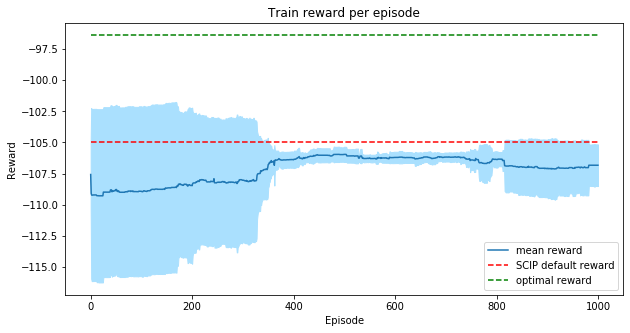

In [13]:
# plot train rewards
plt.figure(figsize =(10,5))

plt.plot(train_rewards_mean, label = 'mean reward')
plt.fill_between(range(episodes+1), train_rewards_mean, train_rewards_mean + train_rewards_std, color = '#AAE0FE')
plt.fill_between(range(episodes+1), train_rewards_mean, train_rewards_mean - train_rewards_std, color = '#AAE0FE')


plt.hlines(train_scip_reward, 0, episodes, linestyles='dashed', colors=['r'], label='SCIP default reward')
plt.hlines(train_opt, 0, episodes, linestyles='dashed', colors=['g'], label='optimal reward')

plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train reward per episode')

plt.show()

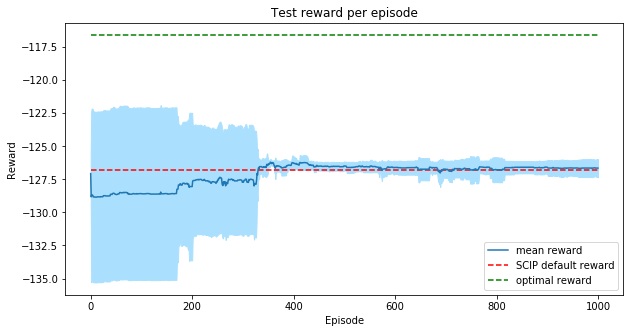

In [14]:
# plot test rewards
plt.figure(figsize =(10,5))

# mean and standard deviation results
plt.plot(test_rewards_mean, label = 'mean reward')
plt.fill_between(range(episodes+1), test_rewards_mean, test_rewards_mean + test_rewards_std, color = '#AAE0FE')
plt.fill_between(range(episodes+1), test_rewards_mean, test_rewards_mean - test_rewards_std, color = '#AAE0FE')

# mean and standard deviation results
plt.hlines(test_scip_reward, 0, episodes, linestyles='dashed', colors=['r'], label='SCIP default reward')
plt.hlines(test_opt, 0, episodes, linestyles='dashed', colors=['g'], label='optimal reward')

plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Test reward per episode')

plt.show()